In [114]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


No vtk


In [115]:
stack_fixed = 'MD592'
train_sample_scheme = 1
global_transform_scheme = 1
trial_idx = 1

In [116]:
# stack_moving = 'atlas_on_MD589'
# stack_moving = 'MD594'
stack_moving = 'atlasV2'

In [117]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', 'SNC', 'SNR', '3N', '4N',
                    'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']
structures = paired_structures + singular_structures

structures_sided = sum([[n] if n in singular_structures else [convert_to_left_name(n), convert_to_right_name(n)]
                        for n in structures], [])

In [118]:
structures_sided_with_surround = sum([[n, n+'_surround'] for n in structures_sided], [])

# Global Transform - between two annotation volumes

In [56]:
global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
DataManager.load_global_alignment_parameters(stack_moving=stack_moving, moving_volume_type='annotation',
                                            stack_fixed=stack_fixed, fixed_volume_type='annotation',
                                            global_transform_scheme=global_transform_scheme)

In [84]:
vol_m = DataManager.load_annotation_volume(stack=stack_moving, downscale=32)

volume_m_alignedTo_f = \
transform_volume(vol=vol_m, global_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f,
                  xdim_f=xdim_f, ydim_f=ydim_f, zdim_f=zdim_f)

volume_m_alignedTo_f_fn = DataManager.get_transformed_volume_filepath(stack_m=stack_moving, type_m='annotation',
                                        stack_f=stack_fixed, type_f='annotation',
                                        downscale=32,
                                        global_transform_scheme=global_transform_scheme)

create_if_not_exists(os.path.dirname(volume_m_alignedTo_f_fn))
bp.pack_ndarray_file(volume_m_alignedTo_f, volume_m_alignedTo_f_fn)

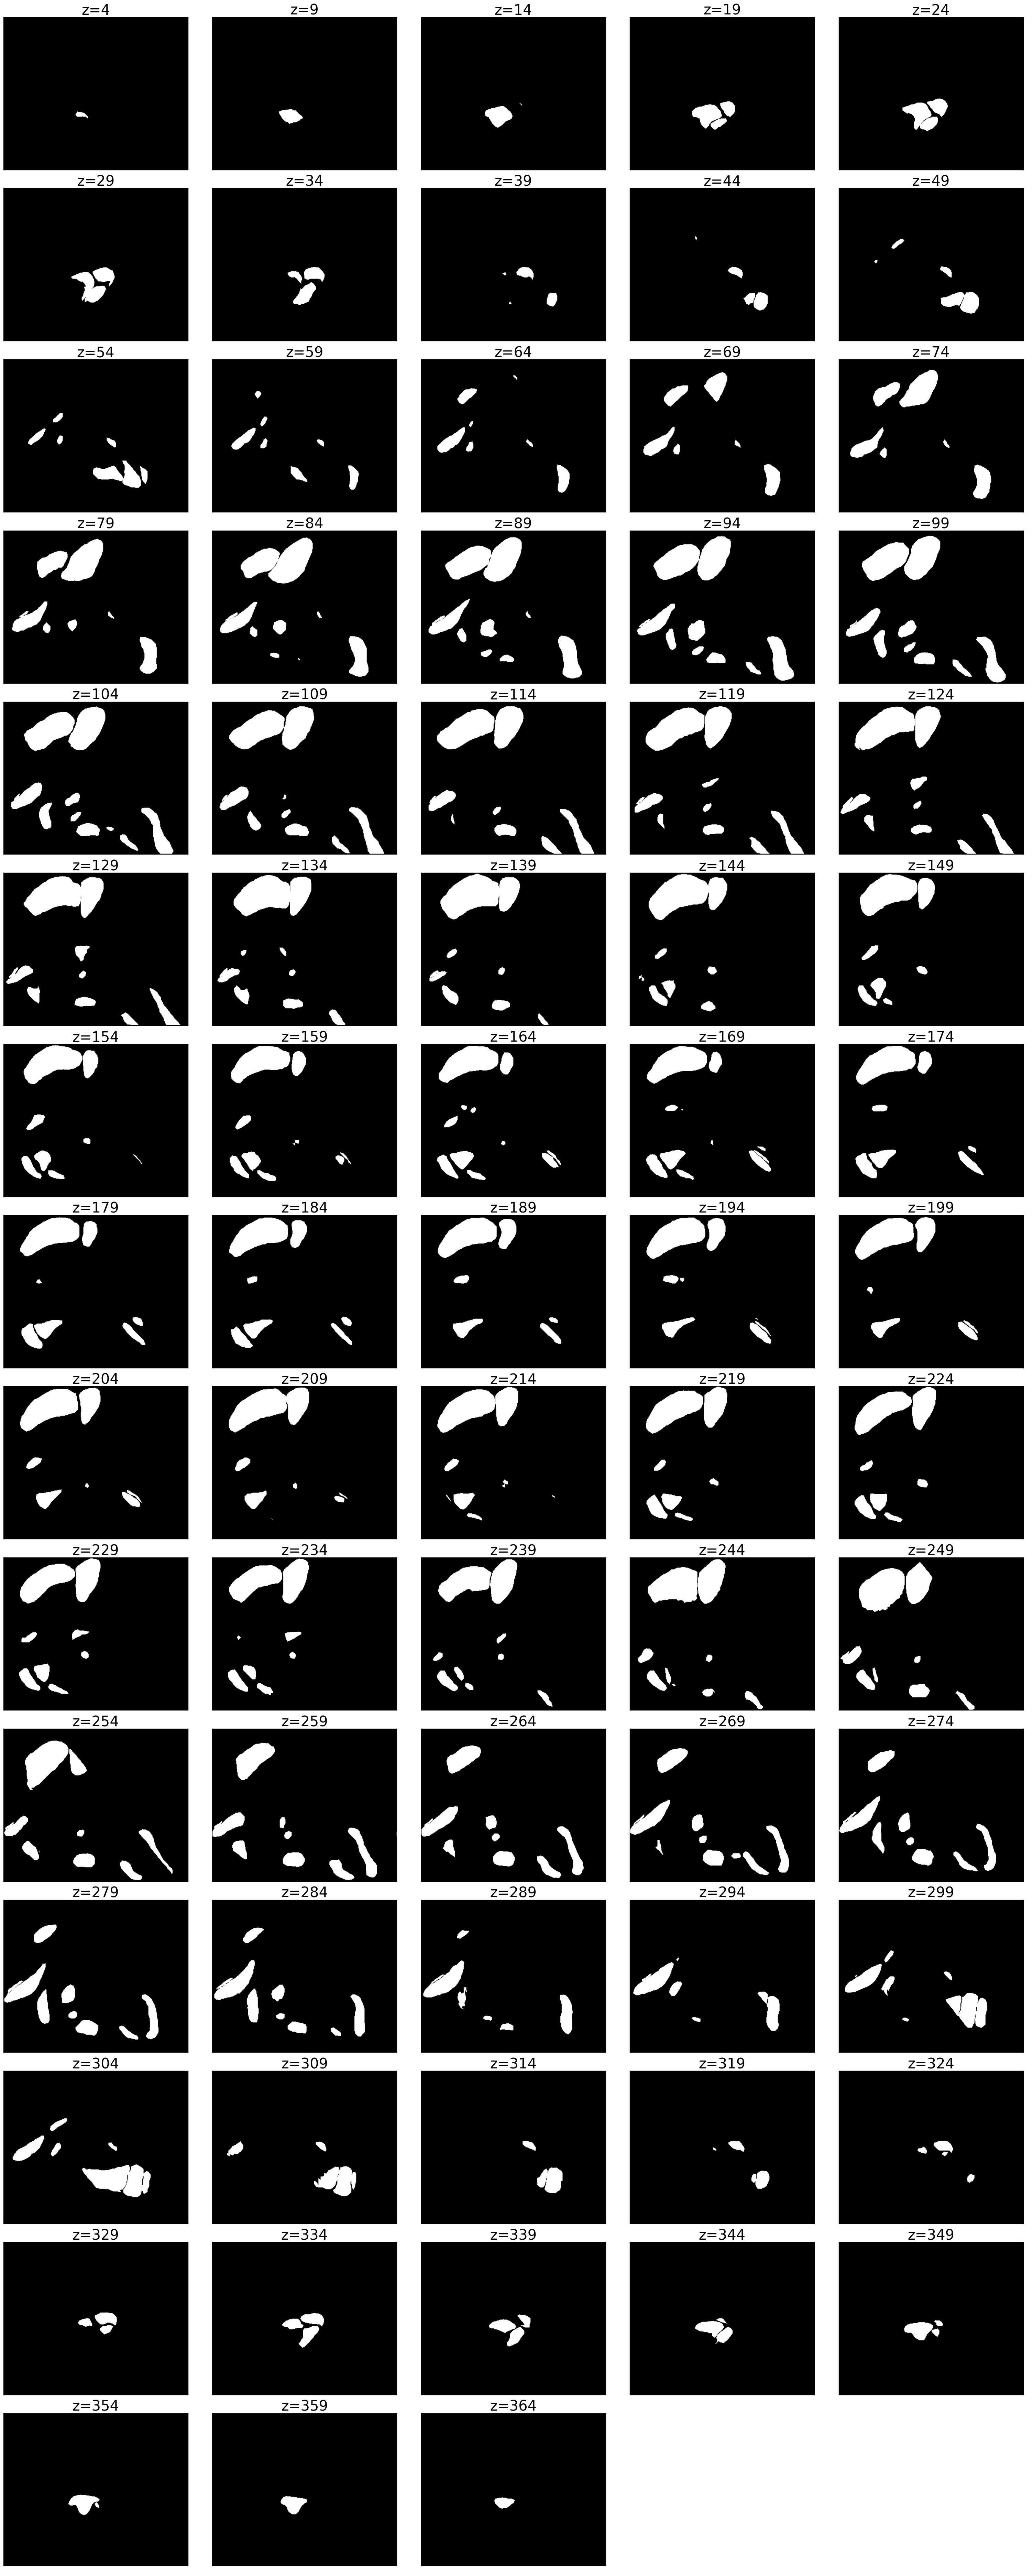

In [88]:
display_volume_sections(volume_m_alignedTo_f)

# Global Transform

In [ ]:
# Load transform parameters

global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
DataManager.load_global_alignment_parameters(stack_moving=stack_moving,
                                            stack_fixed=stack_fixed,
                                            train_sample_scheme=train_sample_scheme,
                                            global_transform_scheme=global_transform_scheme,
                                            trial_idx=trial_idx)

In [ ]:
# Transform moving volume, sided, with surround

for name_s in structures_sided_with_surround:

    print name_s

    vol_m = DataManager.load_score_volume(stack=stack_moving, label=name_s, downscale=32)

    volume_m_alignedTo_f = \
    transform_volume(vol=vol_m, global_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f,
                      xdim_f=xdim_f, ydim_f=ydim_f, zdim_f=zdim_f)

    volume_m_alignedTo_f_fn = DataManager.get_transformed_volume_filepath(stack_m=stack_moving, type_m='score',
                                            stack_f=stack_fixed, type_f='score',
                                            label=name_s,
                                            downscale=32,
                                            train_sample_scheme_f=train_sample_scheme,
                                            global_transform_scheme=global_transform_scheme)

    create_if_not_exists(os.path.dirname(volume_m_alignedTo_f_fn))

    bp.pack_ndarray_file(volume_m_alignedTo_f, volume_m_alignedTo_f_fn)


# Per-structure Transform

In [119]:
local_transform_scheme = 2

In [120]:
for name_s in structures_sided:

    # Read local tx parameters
    local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
    DataManager.load_local_alignment_parameters(stack_moving=stack_moving,
                                                stack_fixed=stack_fixed,
                                                train_sample_scheme=train_sample_scheme,
                                                global_transform_scheme=global_transform_scheme,
                                                 local_transform_scheme=local_transform_scheme,
                                                trial_idx=trial_idx,
                                               label=name_s)
    
    # Read global tx
    global_transformed_moving_structure_vol = DataManager.load_transformed_volume(stack_m=stack_moving, type_m='score',
                                       stack_f=stack_fixed, type_f='score',
                                        downscale=32,
                                        train_sample_scheme_f=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        label=name_s)
    
    # Transform
    local_transformed_moving_structure_vol = transform_volume(vol=global_transformed_moving_structure_vol, 
                                             global_params=local_params, 
                                             centroid_m=centroid_m, centroid_f=centroid_f,
                                             xdim_f=xdim_f, ydim_f=ydim_f, zdim_f=zdim_f)
    
    # Save
    local_transformed_moving_structure_fn = DataManager.get_transformed_volume_filepath(stack_m=stack_moving, type_m='score',
                                   stack_f=stack_fixed, type_f='score',
                                    downscale=32,
                                    train_sample_scheme_f=train_sample_scheme, 
                                    global_transform_scheme=global_transform_scheme, 
                                    local_transform_scheme=local_transform_scheme, 
                                    label=name_s)

    create_if_not_exists(os.path.dirname(local_transformed_moving_structure_fn))
    bp.pack_ndarray_file(local_transformed_moving_structure_vol, local_transformed_moving_structure_fn)

# Global Transform Reversed

In [121]:
global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
DataManager.load_global_alignment_parameters(stack_moving=stack_moving,
                                            stack_fixed=stack_fixed,
                                            train_sample_scheme=train_sample_scheme,
                                            global_transform_scheme=global_transform_scheme,
                                            trial_idx=0)

No vtk


In [122]:
# for name_s in ['7N_L']:
for name_s in structures_sided:
    
    local_transformed_moving_structure_vol = DataManager.load_transformed_volume(stack_m=stack_moving, type_m='score',
                                       stack_f=stack_fixed, type_f='score',
                                        downscale=32,
                                        train_sample_scheme_f=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme,
                                        label=name_s)
    
    local_transformed_moving_structure_global_reversed_vol = transform_volume_inverse(vol=local_transformed_moving_structure_vol, 
                                             global_params=global_params, 
                                             centroid_m=centroid_m, centroid_f=centroid_f,
                                             xdim_m=xdim_m, ydim_m=ydim_m, zdim_m=zdim_m)
    
    local_transformed_moving_structure_global_reversed_fn = DataManager.get_transformed_volume_filepath(stack_m=stack_moving, type_m='score',
                                   stack_f=stack_fixed, type_f='score',
                                    downscale=32,
                                    train_sample_scheme_f=train_sample_scheme, 
                                    global_transform_scheme=global_transform_scheme, 
                                    local_transform_scheme=local_transform_scheme, 
                                    label=name_s, transitive='by')

    create_if_not_exists(os.path.dirname(local_transformed_moving_structure_global_reversed_fn))
    bp.pack_ndarray_file(local_transformed_moving_structure_global_reversed_vol, local_transformed_moving_structure_global_reversed_fn)